In [1]:
# conda create --name gds_metrics pip ipykernel python==3.7.3
# conda activate gds_metrics
# pip install -r ~/dev/Pytolemaic_ptrx/requirements.txt
# pip install dill 
# find ~/opt/anaconda3/envs/gds_metrics/ |grep pytol


In [2]:
# NOT FOR DEV: pip install --no-deps ../Pytolemaic_ptrx/dist/pytolemaic-0.13.14-py3-none-any.whl 
import sys
sys.path.append('/Users/adriansarno/dev/ptx-lab/python_notebooks/Pytolemaic_ptrx/')
sys.path

['/Users/adriansarno/dev/ptx-lab/python_notebooks/metrics',
 '/Users/adriansarno/dev/ptx-lab/python_notebooks/metrics',
 '/Users/adriansarno/Library/Python/3.8/bin',
 '/Users/adriansarno/opt/anaconda3/envs/gds_metrics/lib/python37.zip',
 '/Users/adriansarno/opt/anaconda3/envs/gds_metrics/lib/python3.7',
 '/Users/adriansarno/opt/anaconda3/envs/gds_metrics/lib/python3.7/lib-dynload',
 '',
 '/Users/adriansarno/opt/anaconda3/envs/gds_metrics/lib/python3.7/site-packages',
 '/Users/adriansarno/opt/anaconda3/envs/gds_metrics/lib/python3.7/site-packages/IPython/extensions',
 '/Users/adriansarno/.ipython',
 '/Users/adriansarno/dev/ptx-lab/python_notebooks/Pytolemaic_ptrx/']

In [3]:
import numpy as np
import pandas as pd

from pprint import pprint
from matplotlib import pyplot as plt
import copy
import dill

import sklearn.datasets
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
#
from pytolemaic.pytrust import PyTrust
from pytolemaic.utils.dmd import DMD
from pytolemaic import Metrics
from pytolemaic import PyTrust
from pytolemaic.utils.general import GeneralUtils

print(f'numpy: {np.__version__},  pandas: {pd.__version__},   python: {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')

numpy: 1.19.5,  pandas: 0.25.3,   python: 3.7.3


In [4]:
import warnings
warnings.filterwarnings("ignore")

## Feature Sensitivity  (1 of 3)
* * *

#### Recommended Actions

Feature Importance Report
- Focus effort to improve features with high sensitivity. 
- Discard features with very low sensitivity as, statistically.

Vulnerability Report

    Imputation
    - High values indicate that the imputation mechanism affects the result and thus is important to ensure that it is working correctly.

    Data leakage
    - This mean that the model may be paying attentlin to the wrong data. Obviously any leaks must be removed.

    Too many features 
    1.  higher chance for overfitting
    2.  waste of effort in the data engineering phase. 

        Consider performing feature selection or introducing more regularization.


In [5]:
data = sklearn.datasets.fetch_california_housing(return_X_y=False)

x = data['data']
y = data['target']
feature_names = data['feature_names']

train_inds, test_inds = \
    sklearn.model_selection.train_test_split(np.arange(len(data['data'])), test_size=0.3)

xtrain, ytrain = x[train_inds], y[train_inds]
xtest, ytest = x[test_inds], y[test_inds]


In [6]:
# Adding imputer before RF to support missing values.
# Support missing values is required for calculating sensitivities to missing values 
steps = []
steps.append(('Imputer', SimpleImputer()))
steps.append(('Estimator', RandomForestRegressor(random_state=0, n_estimators=100)))
estimator = Pipeline(steps=steps)

estimator.fit(xtrain, ytrain)

Pipeline(memory=None,
         steps=[('Imputer',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('Estimator',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=None, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=0,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [7]:
pytrust = PyTrust(
    model=estimator,
    xtrain=xtrain, ytrain=ytrain,
    xtest=xtest, ytest=ytest,
    columns_meta={DMD.FEATURE_NAMES: feature_names},
    metric='mae')


- [Required] The trained model, the training set, a holdout testing set and the metric you are using to evaluate the model.
* [Optional] Class labels, splitting strategy
* [Optional] Columns’ metadata: e.g. feature names, feature types, feature encoding
* [Optional] Samples’ metadata: e.g. sample weights


In [8]:
sensitivity_report = pytrust.sensitivity_report

In [9]:
# use pprint for pretty print.
pprint(sensitivity_report.to_dict(), width=120)

{'missing_report': {'method': 'missing',
                    'sensitivities': {'AveBedrms': 0.03025,
                                      'AveOccup': 0.12981,
                                      'AveRooms': 0.05087,
                                      'HouseAge': 0.05721,
                                      'Latitude': 0.23664,
                                      'Longitude': 0.23424,
                                      'MedInc': 0.23897,
                                      'Population': 0.02201},
                    'stats': {'n_features': 8, 'n_low': 0, 'n_very_low': 0, 'n_zero': 0}},
 'shuffle_report': {'method': 'shuffled',
                    'sensitivities': {'AveBedrms': 0.02677,
                                      'AveOccup': 0.13851,
                                      'AveRooms': 0.05067,
                                      'HouseAge': 0.06329,
                                      'Latitude': 0.20398,
                                      'Longitude': 0.18

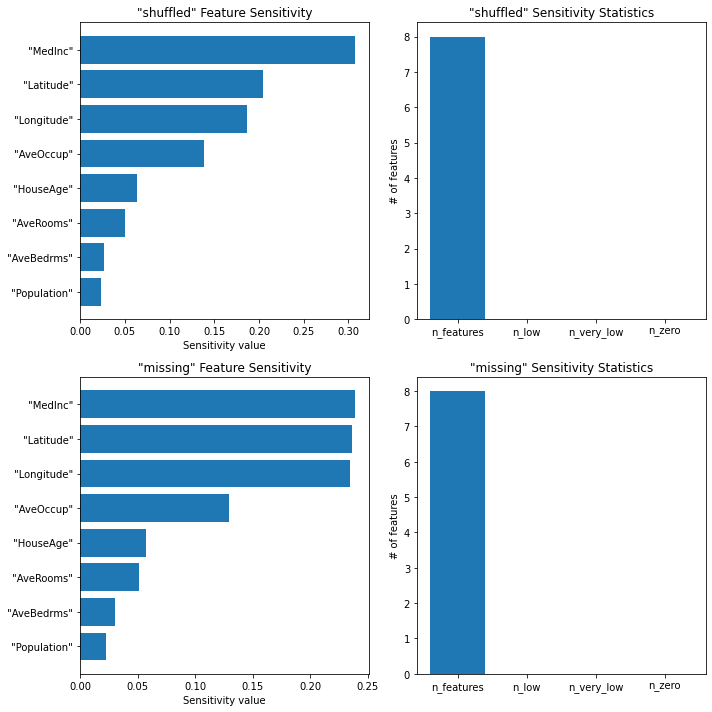

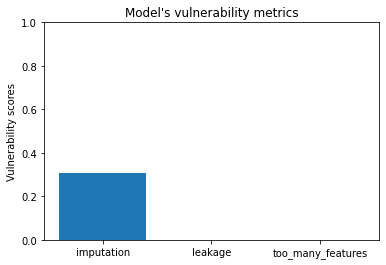

In [10]:
sensitivity_report.plot()

In [11]:
pprint(sensitivity_report.to_dict_meaning(), width=100)

{'missing_report': {'method': 'Method used to calculate sensitivity',
                    'sensitivities': 'key-value dictionary where the key is feature name and value '
                                     'is feature sensitivity',
                    'stats': {'n_features': 'Number of features in dataset',
                              'n_low': 'Number of feature with low sensitivity (sensitivity lower '
                                       'than 5% of max sensitivity)',
                              'n_very_low': 'Number of feature with low sensitivity (sensitivity '
                                            'lower than 5% of max sensitivity)',
                              'n_zero': 'Number of feature with zero sensitivity'}},
 'shuffle_report': {'method': 'Method used to calculate sensitivity',
                    'sensitivities': 'key-value dictionary where the key is feature name and value '
                                     'is feature sensitivity',
                    

# Scoring Reports
* * *

##  Regression (2 of 3)

In the case of a regression task, the uncertainty value represents an error bar, having the same scale as the target variable.

#### Regression Metrics
* MAE: an estimation of the absolute error based on a regressor trained on the absolute error of the test set predictions.
* RMSE: an estimation of the absolute error based on a regressor trained on the squared error of the test set predictions.

In [12]:
scoring_report = pytrust.scoring_report

pprint(scoring_report.to_dict(), width=120)


{'classification_report': None,
 'confusion_matrix': None,
 'metric_scores': {'mae': {'ci_high': 0.34039, 'ci_low': 0.33285, 'ci_ratio': 0.022399144435862533, 'value': 0.33766},
                   'mape': {'ci_high': 0.18839, 'ci_low': 0.18395, 'ci_ratio': 0.02384917011333727, 'value': 0.18504},
                   'mse': {'ci_high': 0.26448, 'ci_low': 0.2557, 'ci_ratio': 0.033757545465031374, 'value': 0.25993},
                   'normalized_rmse': {'ci_high': 0.44519,
                                       'ci_low': 0.43751,
                                       'ci_ratio': 0.01740115554548536,
                                       'value': 0.43955},
                   'r2': {'ci_high': 0.80858, 'ci_low': 0.8018, 'ci_ratio': 0.03480314152250915, 'value': 0.8068},
                   'rmse': {'ci_high': 0.51428, 'ci_low': 0.50567, 'ci_ratio': 0.016883180548066097, 'value': 0.50983}},
 'scatter': {'error_bars': array([0.39556026, 0.54445205, 0.22198485, ..., 0.31007722, 0.68801109,
   

In [13]:
pprint(scoring_report.to_dict_meaning(), width=120)

{'classification_report': "Sklearn's classification report",
 'confusion_matrix': 'Confusion matrix (y_true vs y_pred). Available only for classifiers.',
 'metric_scores': 'Score information for various metrics saved in a dict structure where key is the metric name and '
                  'value is of type ScoringMetricReport',
 'scatter': 'Scatter information (y_true vs y_pred). Available only for regressors.',
 'target_metric': 'Metric of interest'}


In [14]:
# scoring_report.plot()

## Classification (3 0f 3)

In [15]:
# Dataset: xtrain, ytrain, xtest, ytest
data = sklearn.datasets.load_wine(return_X_y=False)

x = data['data']
y = data['target']
feature_names = data['feature_names']
labels = data['target_names']

train_inds, test_inds = sklearn.model_selection.train_test_split(
    np.arange(len(data['data'])), test_size=0.3)

xtrain, ytrain = x[train_inds], y[train_inds]
xtest, ytest = x[test_inds], y[test_inds]

In [16]:
# Train estimator
estimator = DecisionTreeClassifier()
estimator.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [17]:
# Initiating PyTrust
pytrust = PyTrust(
    model=estimator,
    xtrain=xtrain, ytrain=ytrain,
    xtest=xtest, ytest=ytest,
    metric='recall')

In [18]:
scoring_report = pytrust.scoring_report
pprint(scoring_report.to_dict(), width=100)

{'classification_report': {'calibration_curve': {'brier_loss': {0: 0.037037037037037035,
                                                                1: 0.07407407407407407,
                                                                2: 0.037037037037037035},
                                                 'calibration_curve': {0: {'fraction_of_positives': array([0.05128205, 1.        ]),
                                                                           'mean_predicted_value': array([0., 1.])},
                                                                       1: {'fraction_of_positives': array([0.03125   , 0.86363636]),
                                                                           'mean_predicted_value': array([0., 1.])},
                                                                       2: {'fraction_of_positives': array([0.02702703, 0.94117647]),
                                                                           'mean_predicted_value': a

In [19]:
# TODO: copy the class files from sklearn   ***************
# requires newer version of sklearn that spports PrecisionRecallDisplay
# scoring_report.plot()

#### Iris

In [20]:
data = sklearn.datasets.load_iris(return_X_y=False)

x = data['data']
y = data['target']
feature_names = data['feature_names']
labels = data['target_names']

train_inds, test_inds = sklearn.model_selection.train_test_split(
    np.arange(len(data['data'])), test_size=0.3)

xtrain, ytrain = x[train_inds], y[train_inds]
xtest, ytest = x[test_inds], y[test_inds]

In [21]:
# Train estimator
classifier = DecisionTreeClassifier()
classifier.fit(xtrain, ytrain)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [22]:
# Initiating PyTrust
pytrust = PyTrust(
    model=classifier,
    xtrain=xtrain, ytrain=ytrain,
    xtest=xtest, ytest=ytest,
    metric='recall')

In [23]:
scoring_report = pytrust.scoring_report
pprint(scoring_report.to_dict(), width=100)

{'classification_report': {'calibration_curve': {'brier_loss': {0: 0.0,
                                                                1: 0.044444444444444446,
                                                                2: 0.044444444444444446},
                                                 'calibration_curve': {0: {'fraction_of_positives': array([0., 1.]),
                                                                           'mean_predicted_value': array([0., 1.])},
                                                                       1: {'fraction_of_positives': array([0.03448276, 0.9375    ]),
                                                                           'mean_predicted_value': array([0., 1.])},
                                                                       2: {'fraction_of_positives': array([0.03225806, 0.92857143]),
                                                                           'mean_predicted_value': array([0., 1.])}},
              

In [24]:
# TODO: copy the class files from sklearn   ***************
# ~/opt/anaconda3/envs/courses/lib/python3.9/site-packages/sklearn/metrics/_plot/precision_recall_curve.py
# requires newer version of sklearn that spports PrecisionRecallDisplay
# scoring_report.plot()

# Production code
* * *

#### Uncertainty
In the case of a classification task, the uncertainty value represents how unsure the model is in its prediction on a scale of 0 (max confidence) to 1 (no confidence). 

There are two ways to derive an uncertainty metric:
* Probability: an uncertainty measure based on the ratio between the probability values of the 1st and 2nd most probable classes.
* Confidence: an uncertainty measure based on a classifier trained on test set predictions.





In [25]:
def compute_model_uncertainty(classifier, xtest, ytest):
    """The uncertainty value represents how unsure the model is in its prediction 
    on a scale of 0 (max confidence) to 1 (no confidence)."""
    
    # label encoding: not supported DMD expects numeric 
#     print(f'ytest: {ytest[:5]}')
#     labels = ['0', '1', '2']    
#     target_labels={0:labels[0], 1:labels[1], 2:labels[2]}
#     ytest = np.asarray([target_labels[y] for y in ytest])
#     print(f'ytest: {ytest[:5]}')
    print(f'ytest: {ytest[:5]}')
    print(f'classifier.classes_: {classifier.classes_}')
    
    # work with a copy of the model
    estimator = copy.deepcopy(classifier)
    # ensure reproducibility
    np.random.seed(12345) 
    # split test
    test_1st_half_inds, test_2nd_half_inds = sklearn.model_selection.train_test_split(
        np.arange(len(xtest)), test_size=0.5)

    xtest_1st_half, ytest_1st_half = xtest[test_1st_half_inds,:], ytest[test_1st_half_inds]
    xtest_2nd_half, ytest_2nd_half = xtest[test_2nd_half_inds,:], ytest[test_2nd_half_inds]
#     print(f'xtest_1st_half: {xtest_1st_half.shape}')
#     print(f'ytest_1st_half: {ytest_1st_half.shape}')
    
    column_names = [f'col_{i+1}' for i in range(len(xtest_1st_half[0]))]

    # label de-coding: repro error - expects numeric output
#     print(f'estimator.classes_: {estimator.classes_}')
#     estimator.classes_ = np.asarray(['0', '1', '2'])
#     print(f'estimator.classes_: {estimator.classes_}')
    
    # define object
    pytrust = PyTrust(
            model=estimator,
            xtest=xtest_1st_half, ytest=ytest_1st_half,
            feature_names=column_names,
            feature_types=['numerical']*len(column_names),
#             target_labels=target_labels,
            metric=Metrics.recall)

    # compute uncertainty
    uncertainty_model = pytrust.create_uncertainty_model(method='confidence')
    y_pred = uncertainty_model.predict(xtest_2nd_half)  # same as model.predict
    uncertainty = uncertainty_model.uncertainty(xtest_2nd_half) # uncertainty value
    preds_uncertainty = np.concatenate([ytest_2nd_half.reshape(-1,1), y_pred.reshape(-1,1), uncertainty.reshape(-1,1)], axis=1)[:10]
    #
    # print('y_true, y_pred, uncertainty\n',preds_uncertainty)
    mean_uncertainty = round(preds_uncertainty[:,2].mean(),4)
    print(f'\nAvg. uncertainty (confidence method): {mean_uncertainty}')
    
    return mean_uncertainty


def compute_quality_metrics(classifier, xtest, ytest):
    """

    """
    
    compute_model_uncertainty(classifier, xtest, ytest)

In [26]:
# encoding = dmd.target_encoding  # dict property {index: cls_}
# print(f'target classes encoding: {encoding}')
# inv_enc = {cls_: index for index, cls_ in encoding.items()}

# print(f'y_pred: {y_pred}')
# y_pred = numpy.asarray([inv_enc[c] for c in y_pred])
# print(f'y_pred decoded: {y_pred}')
# return y_pred


In [27]:
#??DecisionTreeClassifier

In [28]:
compute_quality_metrics(classifier, xtest, ytest)

ytest: [2 0 0 1 1]
classifier.classes_: [0 1 2]

Avg. uncertainty (confidence method): 0.113



Let's create a Lime explainer
And plot explanation for the first sample in test data: [0.85132344 0.2355672  0.75818347 0.63382511 0.95512603]


Lime explanation is: {'0.23 < triple importance <= 0.35': -0.677257202857141, '0.73 < regular importance #1 <= 0.89': 0.30355591950547406, 'regular importance #3 > 0.91': 0.29218343871320857, '0.58 < regular importance #2 <= 0.71': 0.16839603236942077, '0.77 < zero importance <= 0.89': 0.02740798540969571}

Let's create a Lime explainer
And plot explanation for the first sample in test data: [0.85132344 0.2355672  0.75818347 0.63382511 0.95512603]


Lime explanation is: {'0.23 < triple importance <= 0.35': 0.35350247898066384, '0.58 < regular importance #2 <= 0.71': -0.045367608752545405, 'regular importance #3 > 0.91': 0.04216910925616021, '0.73 < regular importance #1 <= 0.89': 0.023110132289078756, '0.77 < zero importance <= 0.89': -0.02070354986985644}


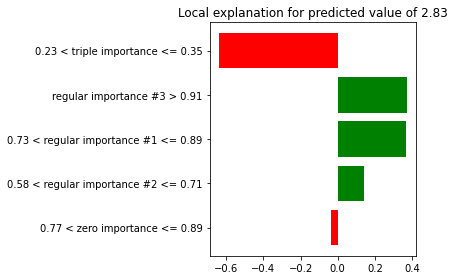

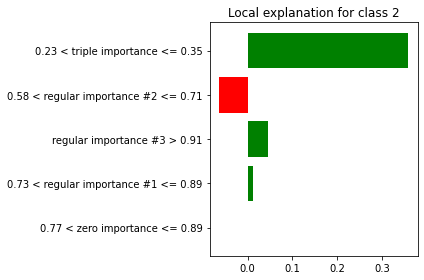

In [29]:
from matplotlib import pyplot as plt

from pytolemaic import PyTrust
from resources.datasets.linear import LinearRegressionDataset, LinearClassificationDataset


def run():
    ## For this example we create train/test data representing a linear function
    # PyTrust supports both numpy and pandas.DataFrame.

    # Obtain simple regression dataset. Use LinearClassificationDataset for classification
    for dataset in [LinearRegressionDataset(), LinearClassificationDataset()]:
        columns_names = dataset.column_names()

        # for quality report, we need for train/test sets and model
        xtrain, ytrain = dataset.training_data
        xtest, ytest = dataset.get_samples()
        estimator = dataset.get_model()

        # set the feature names names
        pytrust = PyTrust(
            model=estimator,
            xtrain=xtrain, ytrain=ytrain,
            xtest=xtest, ytest=ytest,
            feature_names=columns_names,
            feature_types=['numerical']*len(columns_names))

        sample = xtest[0, :]

        # Create explanation for target sample
        print("\nLet's create a Lime explainer")
        lime_explainer = pytrust.create_lime_explainer(max_samples=8000)

        print("And plot explanation for the first sample in test data: {}".format(sample))
        lime_explainer.plot(sample)

        explanation = lime_explainer.explain(sample)
        print("Lime explanation is: {}".format(explanation))
run()